<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="http://introtodeeplearning.com/images/colab/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning_labs/blob/master/lab1/Part2_music_generation.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning_labs/blob/master/lab1/Part2_music_generation.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>


# Lab 1: Intro to TensorFlow and Music Generation with RNNs

# Part 2: Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

## 2.1 Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [0]:
! git clone https://github.com/aamini/introtodeeplearning_labs.git
% cd introtodeeplearning_labs
! git pull
% cd ..

fatal: destination path 'introtodeeplearning_labs' already exists and is not an empty directory.
/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
import tensorflow as tf 
tf.enable_eager_execution()

import numpy as np
import os
import time
import functools

import introtodeeplearning_labs as util

is_correct_tf_version = '1.13.1' in tf.__version__
assert is_correct_tf_version, "Wrong tensorflow version ({}) installed".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled,      "Tensorflow eager mode is not enabled"

'''If this does not return true on Colaboratory, 
    go to runtime -> change runtime type -> GPU
    or see a TA'''
assert tf.test.is_gpu_available()

!apt-get install abcmidi timidity > /dev/null 2>&1

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset: 

In [0]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')

### Inspect the dataset

We can take a look and listen to get a better sense of the dataset:

In [0]:
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 197618 characters


We can grab a song from our dataset as an example and play it back: 

In [0]:
util.play_generated_song(text)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Take a look at the first 250 characters in text
print(text[:250])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [0]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

83 unique characters


<!-- TODO: here explanation of the one-hot encoding, getting the unique characters in the file -->

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
text_as_int = np.array([char2idx[c] for c in text])

# Create a mapping from indices to characters
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [0]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '!' :   2,
  ' ' :   1,
  '#' :   4,
  '"' :   3,
  "'" :   5,
  ')' :   7,
  '(' :   6,
  '-' :   9,
  ',' :   8,
  '/' :  11,
  '.' :  10,
  '1' :  13,
  '0' :  12,
  '3' :  15,
  '2' :  14,
  '5' :  17,
  '4' :  16,
  '7' :  19,
  '6' :  18,
  ...
}



We can also look at how the first part of the text is mapped to an integer representation:

In [0]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'X:1\nT:Alexand' ---- characters mapped to int ---- > [49 22 13  0 45 22 26 67 60 79 56 69 59]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell", and the target sequence "ello".

First, use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices. This is a function within `tf.data` which is generally useful for importing data.

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
# Note how we are using the `tf.data` module!
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

'''TODO: use the batch function to generate sequences of the desired size.'''
'''Hint: youll want to set drop_remainder=True'''
sequences = char_dataset.batch(seq_length+1,drop_remainder=True)
print sequences


<DatasetV1Adapter shapes: (101,), types: tf.int64>


Next, we need to define the input and target texts for each sequence. 

Define a function to do this, and then use the [`map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) method to apply a simple function to each batch. 

In [0]:
'''TODO: define a function that takes a sequence (chunk) and outputs both the input text and target text sequences'''
'''Hint: consider the "Hello" example'''
def split_input_target(chunk):
    input_text =  chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

'''TODO: use the map method to apply your function to the list of sequences to generate the dataset!'''
dataset = sequences.map(lambda x: split_input_target(x))
print(dataset.take(1))

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the `RNN` considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [0]:
for input_example, target_example in dataset.take(1):
  for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
      print("Step {:4d}".format(i))
      print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
      print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 49 ('X')
  expected output: 22 (':')
Step    1
  input: 22 (':')
  expected output: 13 ('1')
Step    2
  input: 13 ('1')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 45 ('T')
Step    4
  input: 45 ('T')
  expected output: 22 (':')


### Create training batches

Great! Now we have our text split into sequences of manageable size. But before we actually feed this data into our model, we'll [`shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the data (for the purpose of stochastic gradient descent) and then pack it into batches which will be used during training.

In [0]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Examine the dimensions of the dataset
dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Let's define some important dimensions:

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
print('vocalb_size=',vocab_size)
# The embedding dimension 
embedding_dim = 84

# The number of RNN units
'''TODO: after running throu？"gh the lab, try changing the number of units in the network to see how it affects performance'''
rnn_units = 1024

('vocalb_size=', 83)


Now, we can define the function that will be used to actually build the model. 

If you'll be running your models on a GPU, you will want to use the [`CuDNNLSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CuDNNLSTM) function:

In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
  return_sequences=True, 
  recurrent_initializer='glorot_uniform',
  stateful=True
)

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      #first layer, an embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    LSTM(rnn_units ), # TODO: Define the dimensionality of the RNN
    tf.keras.layers.Dense(vocab_size) # TODO: Define the dimensionality of the Dense layer
  ])

  return model
########################
#observing the embbeding method
def build_model2(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, 100]),
  ])

  return model

In [0]:
'''TODO: call the build_model function to instantiate the RNN model'''
model = build_model(vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)
"""
model = build_model2(vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)
"""


'\nmodel = build_model2(vocab_size = len(vocab), \n  embedding_dim=embedding_dim, \n  rnn_units=rnn_units, \n  batch_size=BATCH_SIZE)\n'

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [0]:
model.summary()
"""
RNN unit 也就是 output shape的第三項 代表什麼意義呢?
answer:
RNN unit output 一個ht 這個ht送到下一個LSTM中，也出一個output 這個output ht 的size 就是由RNN unit定義的
所以即便妳的input length 跟 embedding size都小於ht 的size ht仍然可以儲存住更大量的訊息
最後一層當然output出 vocabulary size的output
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (64, None, 84)            6972      
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (64, None, 1024)          4546560   
_________________________________________________________________
dense_4 (Dense)              (64, None, 83)            85075     
Total params: 4,638,607
Trainable params: 4,638,607
Non-trainable params: 0
_________________________________________________________________


'\nRNN unit \xe4\xb9\x9f\xe5\xb0\xb1\xe6\x98\xaf output shape\xe7\x9a\x84\xe7\xac\xac\xe4\xb8\x89\xe9\xa0\x85 \xe4\xbb\xa3\xe8\xa1\xa8\xe4\xbb\x80\xe9\xba\xbc\xe6\x84\x8f\xe7\xbe\xa9\xe5\x91\xa2?\nanswer:\nRNN unit output \xe4\xb8\x80\xe5\x80\x8bht \xe9\x80\x99\xe5\x80\x8bht\xe9\x80\x81\xe5\x88\xb0\xe4\xb8\x8b\xe4\xb8\x80\xe5\x80\x8bLSTM\xe4\xb8\xad\xef\xbc\x8c\xe4\xb9\x9f\xe5\x87\xba\xe4\xb8\x80\xe5\x80\x8boutput \xe9\x80\x99\xe5\x80\x8boutput ht \xe7\x9a\x84size \xe5\xb0\xb1\xe6\x98\xaf\xe7\x94\xb1RNN unit\xe5\xae\x9a\xe7\xbe\xa9\xe7\x9a\x84\n\xe6\x89\x80\xe4\xbb\xa5\xe5\x8d\xb3\xe4\xbe\xbf\xe5\xa6\xb3\xe7\x9a\x84input length \xe8\xb7\x9f embedding size\xe9\x83\xbd\xe5\xb0\x8f\xe6\x96\xbcht \xe7\x9a\x84size ht\xe4\xbb\x8d\xe7\x84\xb6\xe5\x8f\xaf\xe4\xbb\xa5\xe5\x84\xb2\xe5\xad\x98\xe4\xbd\x8f\xe6\x9b\xb4\xe5\xa4\xa7\xe9\x87\x8f\xe7\x9a\x84\xe8\xa8\x8a\xe6\x81\xaf\n\xe6\x9c\x80\xe5\xbe\x8c\xe4\xb8\x80\xe5\xb1\xa4\xe7\x95\xb6\xe7\x84\xb6output\xe5\x87\xba vocabulary size\xe7\x9a\x84out

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [0]:
for input_example_batch, target_example_batch in dataset.take(1): 
  print(input_example_batch.shape)
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
print(example_batch_predictions[0])

(64, 100)
(TensorShape([Dimension(64), Dimension(100), Dimension(83)]), '# (batch_size, sequence_length, vocab_size)')
tf.Tensor(
[[-1.4352367e-03  2.2777223e-03 -2.3956101e-03 ... -3.3227084e-03
   6.1450419e-03  9.0395269e-04]
 [-1.2149006e-03  1.2768335e-03 -2.9076964e-03 ... -1.6941848e-03
   5.7632080e-03 -3.0302163e-03]
 [-3.3154907e-03  1.4249582e-03 -3.1120495e-03 ...  6.8969233e-04
   1.0577824e-03 -2.3005926e-03]
 ...
 [ 8.5676974e-03 -3.7905693e-03 -9.7900415e-03 ...  4.8426739e-03
  -1.8385318e-04  6.6603819e-04]
 [ 9.2649339e-03 -1.4804549e-03 -1.0922126e-02 ...  4.8534032e-03
  -5.0827679e-05  5.5308145e-04]
 [ 1.2466580e-02 -2.6541327e-03 -1.0068859e-02 ...  3.4051340e-03
  -1.8069536e-03  1.5673955e-03]], shape=(100, 83), dtype=float32)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices.

Note here that we sample from this probability distribution, as opposed to simply taking the argmax, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [0]:
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
#squeeze 應該是把最大值的取出來

Note how we used a [multinomial distribution](http://onlinestatbook.com/lms/probability/multinomial.html) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep:

In [0]:
sampled_indices

array([35, 55, 41,  0, 58, 13, 16, 59, 57, 52, 56, 70, 80,  9, 42, 44, 73,
       56, 13, 18, 64, 38, 10,  6, 70, 23, 15, 75,  9, 42, 15, 45, 17, 74,
       78,  1,  4, 15,  5,  4, 24, 47, 41, 37,  0,  8, 63,  3, 80, 67, 67,
       10, 14, 57, 53, 43, 76, 30, 22, 61, 41, 74, 19,  6, 32, 20, 31, 21,
       41, 33, 59,  2,  4,  4, 74, 10, 24, 79, 31, 60, 32, 78, 67, 72, 37,
       71, 15, 65, 45, 43,  6, 54, 54,  5, 28, 52, 44, 55, 61, 80])

We can now decode these to see the text predicted by the untrained model:

In [0]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

('Input: \n', "'2A|d^cd faf gfe|afa ged c2A|BAG FAG FED:|!\\nFGA AFd AFd|AFd AFA GED|FGA AFA c2A|BAG FAG FED:|!\\nDED DE'")
()
('Next Char Predictions: \n', '\'J_P\\nc14db[aoy-QSra16iM.(o<3t-Q3T5sw #3\\\'#=VPL\\n,h"yll.2b]RuE:fPs7(G8F9PHd!##s.=xFeGwlqLp3jTR(^^\\\'C[S_fy\'')


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? Training!

### Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. We have the previous state of the RNN as well as the input at a given time step, and want to predict the class of the next character, that is, actually predict the next character. 

So, to train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets and the predicted targets.

Let's first compute the loss using our example predictions from the untrained model: 

In [0]:
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

'''TODO: compute the loss using the example batch and predictions from above'''
example_batch_loss  = compute_loss()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

TypeError: ignored

Now we are ready to define our training operation, i.e., our optimizer and duration of training, and actually train the model. Experiment with the choice of optimizer and the duration for which you train your models, and see how this affects the network's output. Some optimizers you may like to try are `AdamOptimizer`, `AdagradOptimizer`, and `MomentumOptimizer`.

We will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss!

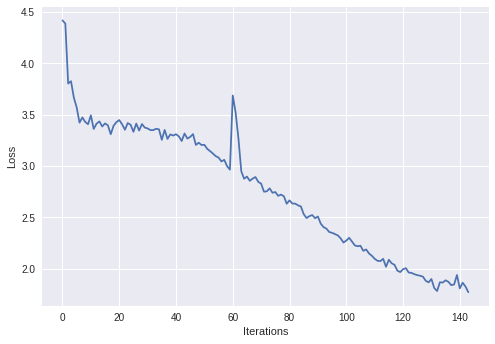

N/A%|#                                              |Time:  0:00:05  Loss: 1.74


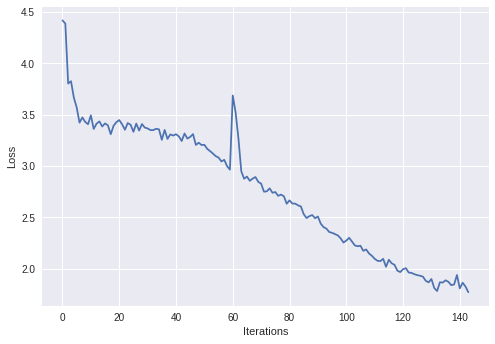

In [0]:
# Training step
import os

EPOCHS = 5 
'''TODO: experiment with different optimizers'''
'''How does changing this affect the network's performance?'''
optimizer = tf.train.AdamOptimizer() # TODO
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

history = []
plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
for epoch in range(EPOCHS):
    start = time.time()

    # Initialize the hidden state at the start of every epoch; initially is None
    hidden = model.reset_states()
    
    # Enumerate the dataset for use in training
    custom_msg = util.custom_progress_text("Loss: %(loss)2.2f")
    bar = util.create_progress_bar(custom_msg)
    for inp, target in bar(dataset):
        # Use tf.GradientTape()
        #print(inp)
        with tf.GradientTape() as tape:
            '''TODO: feed the current input into the model and generate predictions'''
            #print(inp)
            predictions = model(inp) # TODO
            '''TODO: compute the loss!'''
            loss = compute_loss(target,predictions)
        
        # Now, compute the gradients and try to minimize
        '''TODO: complete the function call for gradient computation'''
        grads = tape.gradient(loss,model.trainable_variables) # TODO
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update the progress bar!
        history.append(loss.numpy().mean())
        custom_msg.update_mapping(loss=history[-1])
        plotter.plot(history)
        
    # Update the model with the changed weights!
    model.save_weights(checkpoint_prefix.format(epoch=epoch))



## 2.5 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive caharacters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 84)             6972      
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (1, None, 1024)           4546560   
_________________________________________________________________
dense_5 (Dense)              (1, None, 83)             85075     
Total params: 4,638,607
Trainable params: 4,638,607
Non-trainable params: 0
_________________________________________________________________


Notice how now in our `model.summary` the first dimension of the output shape is 1. This is because we have fed in a fixed `batch_size` of 1.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution of the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state returned is fed back into the model, so that it now has more context. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)
  print(start_string)
  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  #print(input_eval)
  input_eval = tf.expand_dims(input_eval, 0)
  #print(input_eval.numpy().shape)
  #print('hi')
  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  bar = util.create_progress_bar()
  for i in bar(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      #怎麼知道這個input放到對的格子了? A: 只有一格 Q: 那ht是怎麼傳遞的? 每次input玩都會回傳給自己
      ##
      """
      At each time step, the updated RNN state returned is fed back into the model, 
      so that it now has more context. After predicting the next character, the 
      updated RNN states are again fed back into the model, which is how it learns 
      sequence dependencies in the data, as it gets more information from the 
      previous predictions.
      """
      print(input_eval.numpy())
      predictions = model(input_eval) # TODO
      
      # Remove the batch dimension 
      predictions = tf.squeeze(predictions, 0)
      #print("tf.squeeze",predictions)
      '''TODO: use a multinomial distribution to sample'''
      #tf.multinumial 是一個隨機函數 ，從n_class 這個p distribution裡面抽樣 num_samples個東西出來
      predicted_id = tf.multinomial(predictions, num_samples=1,seed=0)[-1,0].numpy() # TODO 
      #print('\#')
      #print( tf.multinomial(predictions, num_samples=1,seed=0)[-1,0])
      #print( tf.multinomial(predictions, num_samples=1,seed=0)[0,0])
      #print( tf.multinomial(predictions, num_samples=1,seed=0)[0,0])
      # Pass the prediction along with the previous hidden state
          # as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      #print(tf.expand_dims([predicted_id], 0).numpy()[0,0])
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in, vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO 

  return (start_string + ''.join(text_generated))

In [0]:
'''TODO: Use the model to generate ABC format text!'''
# As you may notice, ABC files start with "X" - this may be a good start string
text = generate_text(model, start_string="AAAA", generation_length=1000)

  2%|#                                                        |ETA:   0:00:07  

AAAA
[[26 26 26 26]]
[[32]]
[[8]]
[[68]]
[[1]]
[[22]]
[[11]]
[[82]]
[[81]]
[[26]]
[[24]]
[[58]]
[[59]]
[[82]]
[[69]]
[[32]]
[[31]]
[[32]]
[[1]]
[[27]]
[[58]]
[[61]]
[[62]]
[[82]]
[[61]]
[[61]]
[[27]]

  5%|##                                                       |ETA:   0:00:07  


[[56]]
[[1]]
[[60]]
[[15]]
[[59]]
[[60]]
[[82]]
[[61]]
[[27]]
[[59]]
[[1]]
[[53]]
[[2]]
[[0]]
[[49]]
[[22]]
[[14]]
[[14]]
[[16]]
[[0]]
[[45]]
[[22]]
[[1]]
[[64]]
[[67]]
[[60]]
[[70]]
[[60]]


  7%|####                                                     |ETA:   0:00:06  

[[69]]
[[69]]
[[75]]
[[75]]
[[0]]
[[51]]
[[22]]
[[1]]
[[64]]
[[59]]
[[22]]
[[22]]
[[11]]
[[58]]
[[20]]
[[15]]
[[82]]
[[53]]
[[38]]
[[27]]
[[60]]
[[27]]
[[1]]
[[27]]
[[27]]
[[26]]
[[82]]
[[26]]


 10%|#####                                                    |ETA:   0:00:06  

[[29]]
[[31]]
[[1]]
[[26]]
[[14]]
[[32]]
[[82]]
[[26]]
[[31]]
[[26]]
[[1]]
[[30]]
[[26]]
[[59]]
[[82]]
[[27]]
[[26]]
[[31]]
[[59]]
[[1]]
[[31]]
[[15]]
[[22]]
[[82]]
[[2]]
[[0]]
[[0]]
[[49]]
[[22]]


 14%|#######                                                  |ETA:   0:00:06  

[[14]]
[[14]]
[[15]]
[[0]]
[[45]]
[[22]]
[[73]]
[[69]]
[[60]]
[[75]]
[[60]]
[[62]]
[[1]]
[[51]]
[[22]]
[[1]]
[[51]]
[[22]]
[[1]]
[[64]]
[[59]]
[[22]]
[[59]]
[[58]]
[[9]]
[[71]]
[[60]]
[[73]]
[[67]]


 16%|#########                                                |ETA:   0:00:06  

[[61]]
[[15]]
[[14]]
[[11]]
[[64]]
[[0]]
[[38]]
[[22]]
[[1]]
[[64]]
[[59]]
[[58]]
[[59]]
[[58]]
[[9]]
[[74]]
[[67]]
[[60]]
[[67]]
[[67]]
[[9]]
[[13]]
[[19]]
[[17]]
[[0]]
[[38]]
[[22]]
[[28]]


 19%|##########                                               |ETA:   0:00:05  

[[59]]
[[37]]
[[22]]
[[13]]
[[11]]
[[20]]
[[0]]
[[36]]
[[22]]
[[1]]
[[31]]
[[26]]
[[70]]
[[65]]
[[64]]
[[56]]
[[67]]
[[67]]
[[62]]
[[60]]
[[14]]
[[60]]
[[14]]
[[82]]
[[57]]
[[60]]
[[60]]
[[61]]


 21%|############                                             |ETA:   0:00:05  

[[1]]
[[60]]
[[59]]
[[27]]
[[26]]
[[82]]
[[26]]
[[27]]
[[32]]
[[1]]
[[27]]
[[32]]
[[32]]
[[82]]
[[26]]
[[15]]
[[1]]
[[59]]
[[14]]
[[1]]
[[62]]
[[60]]
[[1]]
[[62]]
[[14]]
[[82]]
[[60]]
[[61]]
[[58]]


 25%|##############                                           |ETA:   0:00:05  

[[1]]
[[58]]
[[59]]
[[26]]
[[82]]
[[60]]
[[61]]
[[61]]
[[60]]
[[1]]
[[60]]
[[60]]
[[60]]
[[54]]
[[59]]
[[82]]
[[60]]
[[14]]
[[59]]
[[27]]
[[1]]
[[60]]
[[61]]
[[56]]
[[62]]
[[82]]
[[61]]
[[62]]
[[56]]


 27%|###############                                          |ETA:   0:00:05  

[[56]]
[[1]]
[[61]]
[[60]]
[[59]]
[[82]]
[[60]]
[[58]]
[[59]]
[[1]]
[[60]]
[[59]]
[[54]]
[[60]]
[[82]]
[[61]]
[[60]]
[[61]]
[[1]]
[[56]]
[[61]]
[[61]]
[[82]]
[[58]]
[[26]]
[[27]]
[[1]]
[[26]]


 30%|#################                                        |ETA:   0:00:05  

[[26]]
[[22]]
[[82]]
[[2]]
[[0]]
[[27]]
[[15]]
[[82]]
[[59]]
[[14]]
[[60]]
[[14]]
[[11]]
[[61]]
[[60]]
[[1]]
[[59]]
[[58]]
[[32]]
[[82]]
[[31]]
[[14]]
[[31]]
[[25]]
[[1]]


 33%|##################                                       |ETA:   0:00:04  

[[31]]
[[31]]
[[30]]
[[82]]
[[2]]
[[0]]
[[27]]
[[56]]
[[1]]
[[59]]
[[62]]
[[1]]
[[60]]
[[59]]
[[60]]
[[82]]
[[59]]
[[27]]
[[26]]
[[27]]
[[1]]
[[26]]
[[26]]
[[32]]
[[32]]
[[82]]
[[32]]


 35%|####################                                     |ETA:   0:00:04  

[[27]]
[[58]]
[[27]]
[[1]]
[[26]]
[[14]]
[[22]]
[[82]]
[[0]]
[[56]]
[[62]]
[[61]]
[[1]]
[[62]]
[[27]]
[[58]]
[[82]]
[[27]]
[[14]]
[[58]]
[[58]]
[[1]]
[[58]]
[[26]]
[[31]]
[[32]]
[[82]]


 38%|#####################                                    |ETA:   0:00:04  

[[32]]
[[32]]
[[31]]
[[8]]
[[1]]
[[29]]
[[32]]
[[29]]
[[14]]
[[82]]
[[2]]
[[0]]
[[0]]
[[36]]
[[49]]
[[22]]
[[15]]
[[22]]
[[21]]
[[0]]
[[45]]
[[22]]
[[28]]
[[63]]
[[59]]
[[73]]
[[73]]


 40%|#######################                                  |ETA:   0:00:04  

[[60]]
[[44]]
[[73]]
[[60]]
[[44]]
[[69]]
[[0]]
[[51]]
[[22]]
[[1]]
[[29]]
[[59]]
[[60]]
[[59]]
[[82]]
[[27]]
[[59]]
[[27]]
[[59]]
[[1]]
[[26]]
[[61]]
[[60]]
[[59]]
[[82]]
[[6]]
[[26]]


 43%|########################                                 |ETA:   0:00:04  

[[27]]
[[14]]
[[1]]
[[27]]
[[26]]
[[31]]
[[32]]
[[82]]
[[32]]
[[15]]
[[1]]
[[30]]
[[14]]
[[22]]
[[82]]
[[2]]
[[0]]
[[27]]
[[27]]
[[59]]
[[1]]
[[60]]
[[27]]
[[26]]
[[26]]
[[82]]


 45%|#########################                                |ETA:   0:00:04  

[[27]]
[[27]]
[[26]]
[[59]]
[[1]]
[[26]]
[[14]]
[[61]]
[[82]]
[[62]]
[[14]]
[[5]]
[[60]]
[[1]]
[[56]]
[[62]]
[[61]]
[[82]]
[[60]]
[[59]]
[[61]]
[[1]]
[[60]]
[[61]]
[[61]]
[[61]]
[[82]]


 49%|############################                             |ETA:   0:00:03  

[[60]]
[[59]]
[[31]]
[[1]]
[[32]]
[[31]]
[[29]]
[[82]]
[[31]]
[[14]]
[[27]]
[[1]]
[[27]]
[[59]]
[[27]]
[[59]]
[[82]]
[[61]]
[[56]]
[[54]]
[[60]]
[[1]]
[[60]]
[[60]]
[[58]]
[[82]]
[[59]]


 51%|#############################                            |ETA:   0:00:03  

[[27]]
[[62]]
[[1]]
[[59]]
[[60]]
[[82]]
[[2]]
[[0]]
[[0]]
[[49]]
[[22]]
[[13]]
[[20]]
[[0]]
[[36]]
[[22]]
[[45]]
[[48]]
[[64]]
[[56]]
[[61]]
[[60]]
[[56]]
[[69]]
[[0]]
[[45]]
[[22]]


 54%|###############################                          |ETA:   0:00:03  

[[64]]
[[74]]
[[58]]
[[1]]
[[29]]
[[70]]
[[59]]
[[58]]
[[58]]
[[9]]
[[82]]
[[81]]
[[60]]
[[59]]
[[27]]
[[1]]
[[32]]
[[30]]
[[31]]
[[30]]
[[82]]
[[29]]
[[14]]
[[58]]
[[27]]
[[1]]
[[26]]


 56%|################################                         |ETA:   0:00:03  

[[59]]
[[32]]
[[82]]
[[26]]
[[14]]
[[26]]
[[31]]
[[1]]
[[32]]
[[32]]
[[32]]
[[32]]
[[82]]
[[29]]
[[26]]
[[30]]
[[29]]
[[1]]
[[32]]
[[14]]
[[30]]
[[82]]
[[2]]
[[0]]
[[36]]
[[22]]


 59%|#################################                        |ETA:   0:00:03  

[[31]]
[[27]]
[[1]]
[[38]]
[[65]]
[[32]]
[[82]]
[[27]]
[[26]]
[[26]]
[[1]]
[[31]]
[[26]]
[[32]]
[[26]]
[[82]]
[[30]]
[[31]]
[[32]]
[[1]]
[[26]]
[[32]]
[[24]]
[[82]]
[[32]]
[[27]]
[[1]]


 62%|###################################                      |ETA:   0:00:02  

[[27]]
[[30]]
[[27]]
[[82]]
[[32]]
[[15]]
[[1]]
[[58]]
[[14]]
[[82]]
[[2]]
[[0]]
[[32]]
[[58]]
[[1]]
[[31]]
[[16]]
[[1]]
[[11]]
[[29]]
[[31]]
[[1]]
[[30]]
[[32]]
[[30]]
[[82]]
[[30]]


 64%|####################################                     |ETA:   0:00:02  

[[30]]
[[1]]
[[32]]
[[26]]
[[31]]
[[82]]
[[29]]
[[30]]
[[30]]
[[26]]
[[1]]
[[60]]
[[14]]
[[60]]
[[82]]
[[58]]
[[26]]
[[26]]
[[32]]
[[1]]
[[30]]
[[60]]
[[82]]
[[29]]
[[26]]
[[32]]
[[1]]


 67%|######################################                   |ETA:   0:00:02  

[[30]]
[[27]]
[[26]]
[[82]]
[[53]]
[[2]]
[[0]]
[[59]]
[[14]]
[[82]]
[[2]]
[[0]]
[[0]]
[[49]]
[[22]]
[[16]]
[[1]]
[[45]]
[[22]]
[[64]]
[[60]]
[[75]]
[[60]]
[[1]]
[[70]]
[[1]]


 69%|#######################################                  |ETA:   0:00:02  

[[60]]
[[75]]
[[59]]
[[1]]
[[58]]
[[58]]
[[1]]
[[32]]
[[82]]
[[27]]
[[11]]
[[32]]
[[14]]
[[1]]
[[30]]
[[32]]
[[31]]
[[82]]
[[58]]
[[61]]
[[60]]
[[1]]
[[59]]
[[14]]
[[22]]
[[82]]


 73%|#########################################                |ETA:   0:00:02  

[[2]]
[[0]]
[[52]]
[[14]]
[[82]]
[[61]]
[[15]]
[[1]]
[[60]]
[[14]]
[[1]]
[[27]]
[[58]]
[[31]]
[[82]]
[[32]]
[[27]]
[[59]]
[[1]]
[[26]]
[[59]]
[[22]]
[[82]]
[[64]]
[[59]]
[[60]]
[[60]]


 76%|###########################################              |ETA:   0:00:01  

[[1]]
[[59]]
[[14]]
[[27]]
[[82]]
[[30]]
[[32]]
[[27]]
[[1]]
[[60]]
[[22]]
[[82]]
[[2]]
[[0]]
[[32]]
[[14]]
[[82]]
[[62]]
[[59]]
[[1]]
[[32]]
[[22]]
[[82]]
[[2]]
[[0]]
[[14]]
[[14]]


 78%|############################################             |ETA:   0:00:01  

[[82]]
[[59]]
[[14]]
[[1]]
[[60]]
[[31]]
[[1]]
[[31]]
[[25]]
[[29]]
[[82]]
[[26]]
[[32]]
[[1]]
[[1]]
[[29]]
[[14]]
[[31]]
[[1]]
[[29]]
[[82]]
[[27]]
[[27]]
[[26]]
[[1]]
[[59]]
[[38]]


 81%|##############################################           |ETA:   0:00:01  

[[22]]
[[22]]
[[82]]
[[2]]
[[0]]
[[0]]
[[49]]
[[13]]
[[13]]
[[16]]
[[21]]
[[0]]
[[0]]
[[45]]
[[22]]
[[32]]
[[37]]
[[20]]
[[1]]
[[45]]
[[63]]
[[22]]
[[1]]
[[45]]
[[59]]
[[43]]
[[64]]


 83%|###############################################          |ETA:   0:00:01  

[[69]]
[[22]]
[[74]]
[[0]]
[[51]]
[[22]]
[[17]]
[[0]]
[[37]]
[[22]]
[[22]]
[[11]]
[[20]]
[[0]]
[[36]]
[[22]]
[[26]]
[[27]]
[[1]]
[[38]]
[[56]]
[[65]]
[[70]]
[[14]]
[[56]]
[[82]]


 86%|#################################################        |ETA:   0:00:01  

[[61]]
[[26]]
[[60]]
[[1]]
[[60]]
[[11]]
[[27]]
[[32]]
[[1]]
[[27]]
[[14]]
[[82]]
[[62]]
[[27]]
[[1]]
[[59]]
[[27]]
[[29]]
[[82]]
[[30]]
[[15]]
[[1]]
[[31]]
[[29]]
[[82]]
[[26]]
[[22]]
[[29]]


 89%|###################################################      |ETA:   0:00:00  

[[29]]
[[1]]
[[31]]
[[26]]
[[27]]
[[32]]
[[82]]
[[82]]
[[31]]
[[29]]
[[27]]
[[30]]
[[1]]
[[31]]
[[29]]
[[27]]
[[26]]
[[82]]
[[59]]
[[14]]
[[26]]
[[14]]
[[1]]
[[60]]
[[60]]
[[58]]
[[59]]
[[82]]
[[60]]


 92%|####################################################     |ETA:   0:00:00  

[[15]]
[[26]]
[[32]]
[[1]]
[[26]]
[[14]]
[[31]]
[[32]]
[[82]]
[[29]]
[[14]]
[[26]]
[[27]]
[[1]]
[[31]]
[[26]]
[[32]]
[[27]]
[[82]]
[[2]]
[[58]]
[[62]]
[[14]]
[[1]]
[[27]]
[[61]]
[[59]]
[[27]]
[[82]]


 95%|######################################################   |ETA:   0:00:00  

[[61]]
[[61]]
[[59]]
[[9]]
[[1]]
[[60]]
[[61]]
[[56]]
[[61]]
[[60]]
[[82]]
[[62]]
[[61]]
[[61]]
[[59]]
[[1]]
[[60]]
[[59]]
[[60]]
[[60]]
[[82]]
[[56]]
[[61]]
[[59]]
[[14]]
[[24]]
[[27]]
[[27]]
[[26]]


 97%|#######################################################  |ETA:   0:00:00  

[[82]]
[[60]]
[[61]]
[[82]]
[[60]]
[[62]]
[[60]]
[[60]]
[[1]]
[[60]]
[[61]]
[[61]]
[[60]]
[[82]]
[[56]]
[[56]]
[[61]]
[[62]]
[[56]]
[[82]]
[[57]]
[[56]]
[[60]]
[[57]]
[[62]]
[[82]]
[[60]]
[[61]]
[[57]]


100%|#########################################################|Time:  0:00:07  


[[61]]
[[56]]
[[1]]
[[59]]
[[27]]
[[62]]
[[59]]
[[82]]
[[62]]
[[61]]
[[60]]
[[61]]
[[1]]


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough!

In [0]:
util.play_generated_song(text)

In [0]:
print(text)

## 2.6 Experiment!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

If you want to go further, consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset? 
*  Does the choice of start string significantly affect the result? 

Have fun and happy listening!


![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)



